# API for the decision tree classifier is as following:

## requied import 

In [80]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import precision_recall_fscore_support as score
import pprint

## load data

In [81]:
df=pd.read_csv('train.csv',usecols=['number_project','Work_accident','left','promotion_last_5years','department','salary'])
df.head()

,number_project,Work_accident,promotion_last_5years,department,salary,left
0,7,0,0,sales,low,1
1,4,0,0,sales,low,0
2,2,0,0,accounting,low,1
3,4,0,0,sales,medium,0
4,5,0,0,technical,low,0


In [82]:
#df=pd.read_csv('train.csv')
df = pd.read_csv("train.csv",usecols=['Work_accident','promotion_last_5years','department','salary','left'])
df.head()

,Work_accident,promotion_last_5years,department,salary,left
0,0,0,sales,low,1
1,0,0,sales,low,0
2,0,0,accounting,low,1
3,0,0,sales,medium,0
4,0,0,technical,low,0



## Dividing 80%-20% of data for train and validation purpose

In [83]:
def divide(df,validation_data_size):
    indices = df.index.tolist()
    validation_data_size=round(validation_data_size*len(df))
    validation_indices = random.sample(population=indices, k=validation_data_size)
    train_data = df.drop(validation_indices)
    validation_data = df.loc[validation_indices]
    return train_data,validation_data

In [84]:
random.seed(0)
train_data,validation_data = divide(df,validation_data_size=0.2)

In [85]:
data = train_data.values
data[:10]

array([[0, 0, 'sales', 'low', 1],
       [0, 0, 'accounting', 'low', 1],
       [0, 0, 'technical', 'medium', 0],
       [0, 0, 'product_mng', 'low', 0],
       [0, 0, 'sales', 'low', 0],
       [0, 0, 'marketing', 'medium', 0],
       [0, 0, 'IT', 'medium', 0],
       [0, 0, 'product_mng', 'low', 0],
       [0, 0, 'technical', 'low', 0],
       [0, 0, 'sales', 'medium', 0]], dtype=object)

##   ********** Helper Functions **************

### Check if data has only one unique class

In [86]:
def is_unique_class(data):
    label=data[:, -1]
    classes=np.unique(label)
    if len(classes)==1:
        return True
    else:
        return False

### Classify which has class has majority

In [87]:
def get_class(data):
    #fetch target class labels
    label=data[:,-1]
    #get unique classes and no of unique class
    classes,no_of_classes= np.unique(label,return_counts=True)
    classification=classes[no_of_classes.argmax()]
    return classification

### finding possible divisions for columns (feature)

In [88]:
def possible_division(data):
    
    divisions = {}
    _, n_columns = data.shape
    for column in range(n_columns - 1):
        values=data[:, column]
        unique_values=np.unique(values)
        type_of_feature = types[column]
        
        #for continuous data check > and < conditions
        if type_of_feature == "continuous":
            divisions[column] = []
            for index in range(len(unique_values)):
                if index != 0:
                    current_value=unique_values[index]
                    previous_value=unique_values[index-1]
                    division = (current_value + previous_value)/2
                    divisions[column].append(division)
        
        # for categorical feature check == and != conditions
        else:
            divisions[column]=unique_values
    
    return divisions

### divide data

In [89]:
def divide_data(data,column,value):
    
    column_values = data[:,column]

    type_of_feature = types[column]
    if type_of_feature == "continuous":
        data_on_left = data[column_values <=value]
        data_on_right = data[column_values >value]
    
    # feature is categorical   
    else:
        data_on_left = data[column_values==value]
        data_on_right = data[column_values!=value]
    return data_on_left, data_on_right

In [90]:
def get_best_division(data, divisions):
    
    min_entropy = 500
    for column in divisions:
        for value in divisions[column]:
            data_on_left, data_on_right = divide_data(data,column=column,value=value)
            current_entropy = get_total_entropy(data_on_left, data_on_right)
            if current_entropy <= min_entropy:
                min_entropy = current_entropy
                division_column=column
                division_value=value
    
    return division_column,division_value


### calculate entropy,gini index to select the feature with lowest total entropy or gini index

In [91]:
def entropy(data):
    label=data[:, -1]
    _,counts=np.unique(label,return_counts=True)
    probabilities=counts/counts.sum()
    ent=sum(probabilities * -np.log2(probabilities))
    #print(type(probabilities))
    #gini=1-sum([ i**2 for i in probabilities]) 
    #return gini
    return ent
    #return 1-np.max(probabilities)




In [92]:
def get_total_entropy(data_on_left, data_on_right):
    p_data_on_left = len(data_on_left) / (len(data_on_left) + len(data_on_right))
    p_data_on_right = len(data_on_right) / (len(data_on_left) + len(data_on_right))
    total_entropy=(p_data_on_left*entropy(data_on_left)+p_data_on_right*entropy(data_on_right))
    return total_entropy

### Get type of feature (categorical or continuous)

In [93]:
def get_feature_type(data):
    feat_types=[]
    threshold = 15
    for feature in data.columns:
        if feature != "label":
            unique_vals=data[feature].unique()
            example_value=unique_vals[0]
            # for categorical data entries might be string and unique values may be low than threshold
            if (isinstance(example_value, str)) or (len(unique_vals) <= threshold):
                feat_types.append("categorical")
            else:
                feat_types.append("continuous")
    
    return feat_types

### Decision tree Algorithm

In [94]:
#global value for number of nodes
no_of_nodes=0

# increment function

def increment(c):
    global no_of_nodes
    no_of_nodes += c

#resetting the value to 0
def set_zero():
    global no_of_nodes
    no_of_nodes=0

#for accessing no_of_nodes variable
def get_nodes():
    global no_of_nodes
    return no_of_nodes

def id3_tree(df, cnt=0, min_samples=2, max_depth=8):
    #for first function call categorize columns into continuous and categorical
    if cnt == 0:
        global heading, types
        heading = df.columns
        types = get_feature_type(df)
        data = df.values
    else:
        data = df           
    if len(data)==0 :
        return
    
    # base case
    #if unique instance of yes or no in data
    # length of tree reached maximum
    #data has features than min_samples 
    if (is_unique_class(data)) or (len(data) < min_samples) or (cnt == max_depth):
        classification = get_class(data)
        increment(1)
        return classification

    # still data is not pure according to provided parameters
    else:    
        cnt += 1
        increment(2)
        # helper functions 
        possible_divisions = possible_division(data)
        column,value = get_best_division(data, possible_divisions)
        data_on_left,data_on_right=divide_data(data,column,value)
        
        # determine question
        feature_name = heading[column]
        if types[column]=="continuous":
            question = "{} <= {}".format(feature_name,value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name,value)
        
        # new sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        pos=id3_tree(data_on_left, cnt, min_samples, max_depth)
        neg=id3_tree(data_on_right,cnt, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if pos==neg:
            sub_tree=pos
        else:
            sub_tree[question].append(pos)
            sub_tree[question].append(neg)
        return sub_tree

### Buiding a tree

In [106]:
tree = id3_tree(train_data, max_depth=10)
pprint.pprint(tree)
print("number of nodes",no_of_nodes) 

{'left = 1': [{'prediction = 1': [True, False]},
              {'prediction = 1': [False, True]}]}
number of nodes 1317


## Prediction

In [96]:
sample_entry=validation_data.iloc[0]

In [97]:
def predict(sample, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if sample[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # for categorical feature
    else:
        if str(sample[feature_name]) == value:
            answer=tree[question][0]
        else:
            answer=tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # go deeper into the tree
    else:
        sub_tree=answer
        return predict(sample,sub_tree)

In [98]:
print(sample_entry)
predict(sample_entry, tree)

Work_accident                 0
promotion_last_5years         0
department                sales
salary                   medium
left                          1
Name: 6311, dtype: object


0

# Calculate Accuracy

In [99]:
def get_accuracy(data, tree):

    data["prediction"] = data.apply(predict,args=(tree,),axis=1)
    data["correct_prediction"]= data["prediction"]==data["left"]
    acc= data["correct_prediction"].mean()
    #df["prediction"].head()
    a,b,c,d=score(data["left"],data["prediction"])
    #calculation of precision ,recall and F1 score
    print("precision:",a[0])
    print("recall:",b[0])
    print("fscore:",c[0])
    return acc

In [100]:
print(get_accuracy(validation_data,tree))

precision: 0.7485536270583
recall: 1.0
fscore: 0.856197505726648
0.7486654804270463


# 4. Visualization of Training Data

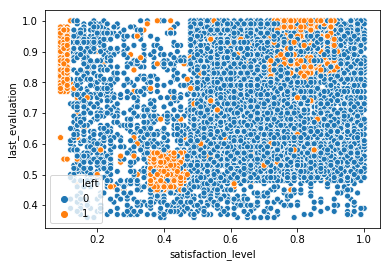

In [101]:
#plt.scatter(df.average_montly_hours, df.satisfaction_level)
dt=pd.read_csv('train.csv')
sns.scatterplot(x="satisfaction_level",y="last_evaluation",data=dt,hue='left')
#sns.lmplot(x="number_project",y="satisfaction_level",data=dt,hue='left',fit_reg=True)
#sns.pairplot(dt,hue='left')

# 5. Number of nodes vs Validation error

In [102]:
validation_error=[]
number_of_nods=[]
for i in range (5,20):
    global no_of_nodes
    #print("value of no of nodes:",no_of_nodes)
    set_zero()
    tree = id3_tree(train_data,max_depth=i)
    print("value of no of nodes:",no_of_nodes)
    accuracy =get_accuracy(validation_data,tree)
    print("test:",i-4)
    number_of_nods.append(get_nodes())
    validation_error.append(1-accuracy)
    accuracy
    



value of no of nodes: 66
precision: 0.748220640569395
recall: 1.0
fscore: 0.8559796437659033
test: 1


/home/ajay/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


value of no of nodes: 104
precision: 0.748220640569395
recall: 1.0
fscore: 0.8559796437659033
test: 2
value of no of nodes: 152
precision: 0.748220640569395
recall: 1.0
fscore: 0.8559796437659033
test: 3
value of no of nodes: 210
precision: 0.7485536270583
recall: 1.0
fscore: 0.856197505726648
test: 4
value of no of nodes: 279
precision: 0.7485536270583
recall: 1.0
fscore: 0.856197505726648
test: 5
value of no of nodes: 354
precision: 0.7485536270583
recall: 1.0
fscore: 0.856197505726648
test: 6
value of no of nodes: 439
precision: 0.7485536270583
recall: 1.0
fscore: 0.856197505726648
test: 7
value of no of nodes: 534
precision: 0.7485536270583
recall: 1.0
fscore: 0.856197505726648
test: 8
value of no of nodes: 638
precision: 0.7485536270583
recall: 1.0
fscore: 0.856197505726648
test: 9
value of no of nodes: 746
precision: 0.7485536270583
recall: 1.0
fscore: 0.856197505726648
test: 10
value of no of nodes: 854
precision: 0.7485536270583
recall: 1.0
fscore: 0.856197505726648
test: 11
va

# Graph :Number of nodes vs Validation Error

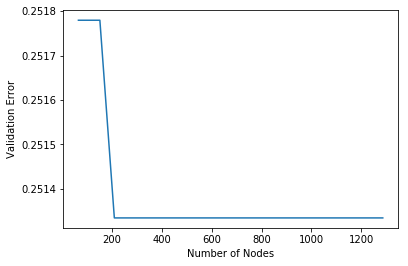

In [103]:
plt.plot(number_of_nods,validation_error)
plt.xlabel("Number of Nodes")
plt.ylabel("Validation Error")
plt.show()



# 5.Number of Nodes vs Training Error



In [104]:
#train_df.drop(['classification'])
training_error=[]
no_of_nods=[]
for i in range(5,20):
    set_zero()
    train_data,validation_data=divide(df,validation_data_size=0.2)
    tree=id3_tree(train_data,max_depth=i)
    acc=get_accuracy(train_data,tree)
    print("test:",i-4)
    no_of_nods.append(get_nodes())
    training_error.append(1-accuracy)

/home/ajay/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision: 0.7619577308120133
recall: 1.0
fscore: 0.86489898989899
test: 1
precision: 0.7627099788630548
recall: 1.0
fscore: 0.8653834017040076
test: 2
precision: 0.7615975080654133
recall: 1.0
fscore: 0.864666877170824
test: 3
precision: 0.7580376015129603
recall: 1.0
fscore: 0.8623679048281973
test: 4
precision: 0.763717306622148
recall: 0.9998542911263296
fscore: 0.8659767794043413
test: 5
precision: 0.7689566863378243
recall: 0.9997104806022004
fscore: 0.8692806344011581
test: 6
precision: 0.7630553390491036
recall: 0.999708242159008
fscore: 0.8654963374589543
test: 7
precision: 0.7621645696470326
recall: 0.9997079012706295
fscore: 0.8649229214051048
test: 8
precision: 0.763415720329548
recall: 0.9998541848935549
fscore: 0.8657828282828283
test: 9
precision: 0.7578220688119363
recall: 0.9997062279670975
fscore: 0.8621191969092405
test: 10
precision: 0.7613851464202205
recall: 0.9997076023391813
fscore: 0.8644207066557108
test: 11
precision: 0.760939761719185
recall: 0.9997074312463

#  Graph: Number of nodes vs Training Error 

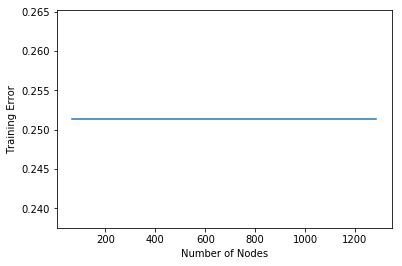

In [105]:
plt.plot(number_of_nods,training_error)
plt.xlabel("Number of Nodes")
plt.ylabel("Training Error")
plt.show()


### Note: accuracy of predictions based on only categorial data is very low, If we use number_project and time_spend_company data as categorial data accuracy can be improved.